In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from pyhocon import ConfigFactory
import rllr.env as environments
from rllr.algo import PPOGAN
from rllr.models import encoders, ActorCriticNetwork, StateEmbedder

import sys
sys.path.append('../../experiments/minigrid/')
from vae import VAE, init_params
from train_master_gan import VAEEncoder, VAEDecoder

In [2]:
vae_state_dict = torch.load('../../experiments/minigrid/vae.pt', map_location='cpu')
vae = VAE((64,64,3))
vae.load_state_dict(vae_state_dict)

<All keys matched successfully>

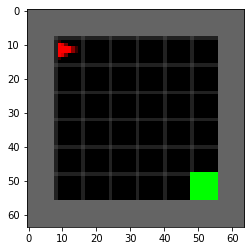

In [3]:
conf = '../../experiments/minigrid/conf/minigrid_second_step_random_empty.hocon'
conf = ConfigFactory.parse_file(conf)
env = environments.minigrid_envs.gen_wrapped_env(conf['env'], verbose=False)

obs = env.reset()
plt.imshow(obs)

In [4]:
all_states = list()
for i in range(6):
    for j in range(6):
        for k in range(4):
            env.unwrapped.agent_pos = np.array([i+1, j+1])
            env.unwrapped.agent_dir = k
            obs, _, _, _ = env.step(1)
            all_states.append(obs)

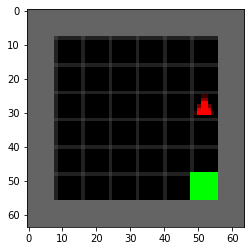

In [5]:
plt.imshow(all_states[130])

In [6]:
print(all_states[32].min(), all_states[32].max(), all_states[32].shape)

0 255 (64, 64, 3)


In [7]:
master_with_gan = '../../experiments/artifacts/minigrid/models/minigrid_master_random_empty.p'
master_with_gan = torch.load(master_with_gan, map_location='cpu')
master_without_gan = '../../experiments/artifacts/minigrid/models/minigrid_master_random_empty_1.p'
master_without_gan = torch.load(master_without_gan, map_location='cpu')

In [8]:
all_states = torch.from_numpy(np.stack(all_states, axis=0))
with torch.no_grad():
    _, mu, logvar = vae(all_states)
    std = torch.sqrt(torch.exp(logvar))
    vae_states_distr = torch.distributions.Normal(mu, std)
    goal_with_gan = master_with_gan.actor_critic.deterministic_forward(all_states, 0, 0)
    goal_without_gan = master_without_gan.actor_critic.deterministic_forward(all_states, 0, 0)

In [9]:
probs_mu = list()
probs_with_gan = list()
probs_without_gan = list()

for i in range(mu.shape[0]):
    probs_mu.append(torch.exp(vae_states_distr.log_prob(mu[i])).mean(dim=-1).max())
    probs_with_gan.append(torch.exp(vae_states_distr.log_prob(goal_with_gan[i])).mean(dim=-1).max())
    probs_without_gan.append(torch.exp(vae_states_distr.log_prob(goal_without_gan[i])).mean(dim=-1).max())

probs_mu = torch.stack(probs_mu, dim=0).numpy()
probs_with_gan = torch.stack(probs_with_gan, dim=0).numpy()
probs_without_gan = torch.stack(probs_without_gan, dim=0).numpy()

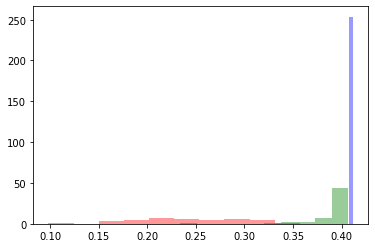

In [10]:
plt.hist(probs_mu, color='b', alpha=0.4, density=True, bins=1)
plt.hist(probs_with_gan, color='g', alpha=0.4, density=True)
plt.hist(probs_without_gan, color='r', alpha=0.4, density=True)
plt.show()